In [2]:
import requests
import pandas as pd
import numpy as np
from lxml import etree
from bs4 import BeautifulSoup as bsoup
import os
import json
!conda install -c conda-forge geocoder
import geocoder

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.6.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

# use the inline backend to generate the plots within the browser
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot') # optional: for ggplot-like style

# check for latest version of Matplotlib
print ('Matplotlib version: ', mpl.__version__) # >= 2.0.0

Fetching package metadata .............
Solving package specifications: .

Package plan for installation in environment /opt/conda/envs/DSX-Python35:

The following NEW packages will be INSTALLED:

    geocoder:   1.38.1-py_0  conda-forge
    orderedset: 2.0-py35_0   conda-forge
    ratelim:    0.1.6-py35_0 conda-forge

orderedset-2.0 100% |################################| Time: 0:00:00   1.30 MB/s
ratelim-0.1.6- 100% |################################| Time: 0:00:00   7.49 MB/s
geocoder-1.38. 100% |################################| Time: 0:00:00  30.91 MB/s
Fetching package metadata .............
Solving package specifications: .

Package plan for installation in environment /opt/conda/envs/DSX-Python35:

The following NEW packages will be INSTALLED:

    altair:  2.2.2-py_0 conda-forge
    branca:  0.3.0-py_0 conda-forge
    folium:  0.6.0-py_0 conda-forge
    vincent: 0.4.4-py_1 conda-forge

branca-0.3.0-p 100% |################################| Time: 0:00:00 778.36 kB/s
vincent-0.4

In [3]:
# The code was removed by Watson Studio for sharing.

## GET TORONTO DATA

In [4]:
# CAUTION: The structure of postal code table had some changes, these under line of codes will cover these changes.
# However, because I saved my data set by csv file and shared on my github, I just get Toronto postal codes from that file.
# If you want to get new lasted data, you can comment out these line of codes.
#wikipedia_link='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
#raw_random_wikipedia_page = requests.get(wikipedia_link)
#page = raw_random_wikipedia_page.text
#soup = bsoup(page, "lxml")
#tablePostalCode = soup.find_all("table")[0]
#rows = tablePostalCode.tbody.find_all("tr")
#listPostalCode = []
#for row in rows:
#    if row.th is not None:
#        continue
#    if "Not assigned" in row.text:
#        continue
#    tds = row.find_all("td")
#    listTemp = []
#    for td in tds:
#        listTemp.append(td.text)
#    listPostalCode.append({"PostalCode": listTemp[0], "Borough": listTemp[1], "Neighborhood": listTemp[2].replace('\n', '')})

#columns = ["PostalCode", "Borough", "Neighborhood"]
#dfTorontoPostalCode = pd.DataFrame.from_records(data=listPostalCode, columns=columns)
#dfTorontoPostalCode.head()
dfTorontoPostalCode = pd.read_csv('https://raw.githubusercontent.com/timbake/TheBattleOfNeighborhoods/master/TorontoPostalCode.csv')

In [5]:
dfTorontoPostalCode.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,Regent Park / Harbourfront,43.654260,-79.360636
3,M6A,North York,Lawrence Manor / Lawrence Heights,43.718518,-79.464763
4,M7A,Queen's Park,Queen's Park,43.662301,-79.389494


In [6]:
def updateLatLngForTorontoPostalCodeUseGeocoder(dfPostalCode, loadAPI = False):
    if os.path.isfile('TorontoPostalCode.csv') and loadAPI == False:
        print("Load data from csv")
        dfPostalCode = pd.read_csv('TorontoPostalCode.csv')
    else:
        latitude = []
        longitude = []

        for pc in dfPostalCode["PostalCode"].values:
            coordsLatLng = None
            while(coordsLatLng is None):
                g = geocoder.google('{}, Toronto, Ontario'.format(pc))
                coordsLatLng = g.latlng

            latitude.append(coordsLatLng[0])
            longitude.append(coordsLatLng[1])

        dfPostalCode['Latitude'] = latitude
        dfPostalCode['Longitude'] = longitude

    return dfPostalCode

In [7]:
# I don't need use method when I get Toronto data that I saved to github.
# Toronto Postal Code included Coordinates (Latitude, Longitude)
#dfTorontoPostalCode = updateLatLngForTorontoPostalCodeUseGeocoder(dfTorontoPostalCode, True)
#dfTorontoPostalCode.head()

In [8]:
# The code was removed by Watson Studio for sharing.

In [9]:
def getRecommendedVenues(names, latitudes, longitudes, radius=500, limit=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, limit)
            
        # make the GET request
        result = requests.get(url).json()
        if "code" not in result["meta"] or result["meta"]["code"] != 200:
            print("No info at Neighborhood {0} ({1}, {2}) WITH CODE {3}".format(name, lat, lng, result["meta"]["code"] if "code" in result["meta"] else "UNKNOWN"))
            return None
        response = result['response']
        if "warning" in response and "text" in response["warning"]:
            print(response["warning"]["text"])
            return None
        results = response['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng,
            v['reasons']['count'],
            ", ".join([reason["summary"] for reason in v['reasons']["items"]]),
            v['venue']['id'], 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['location']['formattedAddress'][0],
            v['venue']['categories'][0]['id'],
            v['venue']['categories'][0]['name'],
            v['venue']['categories'][0]['icon']['prefix'] + v['venue']['categories'][0]['icon']['suffix']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Number of Recommendation',
                  'Recommend Reason',  
                  'Venue ID', 
                  'Venue Name',           
                  'Venue Latitude', 
                  'Venue Longitude',
                  'Venue Address', 
                  'Category ID', 
                  'Category Name', 
                  'Category ICON']
    
    return(nearby_venues)

In [10]:
# I also don't need use this function to get venues related to each postal code.
# If you want to test this function
#dfTorontoRVenues = getRecommendedVenues(dfTorontoPostalCode['Neighborhood'], dfTorontoPostalCode['Latitude'], dfTorontoPostalCode['Longitude'], radius=500)
dfTorontoRVenues = pd.read_csv('https://raw.githubusercontent.com/timbake/TheBattleOfNeighborhoods/master/TorontoRVenues.csv')
dfTorontoRVenues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Number of Recommendation,Recommend Reason,Venue ID,Venue Name,Venue Latitude,Venue Longitude,Venue Address,Category ID,Category Name,Category ICON,City
0,Victoria Village,43.725882,-79.315572,0,This spot is popular,4c633acb86b6be9a61268e34,Victoria Village Arena,43.723481,-79.315635,['Canada'],4bf58dd8d48988d185941735,Hockey Arena,https://ss3.4sqi.net/img/categories_v2/arts_en...,Toronto
1,Victoria Village,43.725882,-79.315572,0,This spot is popular,4f3ecce6e4b0587016b6f30d,Portugril,43.725819,-79.312785,"['1733 Eglinton Avenue East (Bermondsey)', 'To...",4def73e84765ae376e57713a,Portuguese Restaurant,https://ss3.4sqi.net/img/categories_v2/food/po...,Toronto
2,Victoria Village,43.725882,-79.315572,0,This spot is popular,4bbe904a85fbb713420d7167,Tim Hortons,43.725517,-79.313103,"['1733 Eglinton Ave East (at Bermondsey Rd)', ...",4bf58dd8d48988d1e0931735,Coffee Shop,https://ss3.4sqi.net/img/categories_v2/food/co...,Toronto
3,Victoria Village,43.725882,-79.315572,0,This spot is popular,51e594d5498e07837484f577,Eglinton Ave E & Sloane Ave/Bermondsey Rd,43.726086,-79.313620,['Eglinton Avenue East (at Sloan Avenue / Berm...,52f2ab2ebcbc57f1066b8b4c,Intersection,https://ss3.4sqi.net/img/categories_v2/travel/...,Toronto
4,Regent Park / Harbourfront,43.654260,-79.360636,0,This spot is popular,54ea41ad498e9a11e9e13308,Roselle Desserts,43.653447,-79.362017,"['362 King St E (Trinity St)', 'Toronto ON M5A...",4bf58dd8d48988d16a941735,Bakery,https://ss3.4sqi.net/img/categories_v2/food/ba...,Toronto


## GET NEW YORK DATA

In [11]:
# I also don't need use these line of codes when I get New York data that I saved to github.
#r = requests.get("https://ibm.box.com/shared/static/fbpwbovar7lf8p5sgddm06cgipa2rxpe.json", allow_redirects=True)
#open('newyork_data.json', 'wb').write(r.content)
#print('Data downloaded!')

#with open('newyork_data.json') as json_data:
#    newyork_data = json.load(json_data)

#listNewYorkNeighborhood = newyork_data['features']
# define the dataframe columns
#listColumnNewYork = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
#dfNewYorkNeighborhood = pd.DataFrame(columns=listColumnNewYork)

# transform data to dataframe
#for data in listNewYorkNeighborhood:
#    borough = data['properties']['borough'] 
#    neighborhood = data['properties']['name']
        
#    latlon = data['geometry']['coordinates']
#    lat = latlon[1]
#    lon = latlon[0]
    
#    dfNewYorkNeighborhood = dfNewYorkNeighborhood.append({'Borough': borough,
#                                          'Neighborhood': neighborhood,
#                                          'Latitude': lat,
#                                          'Longitude': lon}, ignore_index=True)

In [12]:
dfNewYorkNeighborhood = pd.read_csv('https://raw.githubusercontent.com/timbake/TheBattleOfNeighborhoods/master/NewYorkNeighborhood.csv')
dfNewYorkNeighborhood.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [13]:
# dfNewYorkRVenues = getRecommendedVenues(dfNewYorkNeighborhood['Neighborhood'], dfNewYorkNeighborhood['Latitude'], dfNewYorkNeighborhood['Longitude'], radius=500)
dfNewYorkRVenues = pd.read_csv('https://raw.githubusercontent.com/timbake/TheBattleOfNeighborhoods/master/NewYorkRVenues.csv')
dfNewYorkRVenues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Number of Recommendation,Recommend Reason,Venue ID,Venue Name,Venue Latitude,Venue Longitude,Venue Address,Category ID,Category Name,Category ICON,City
0,Wakefield,40.894705,-73.847201,0,This spot is popular,4c537892fd2ea593cb077a28,Lollipops Gelato,40.894123,-73.845892,['4120 Baychester Ave (Edenwald & Bussing Ave)...,4bf58dd8d48988d1d0941735,Dessert Shop,https://ss3.4sqi.net/img/categories_v2/food/de...,New York
1,Wakefield,40.894705,-73.847201,0,This spot is popular,4d6af9426107f04dedeb297a,Rite Aid,40.896521,-73.844680,"['4232 Baychester Ave', 'Bronx, NY 10466', 'Un...",4bf58dd8d48988d10f951735,Pharmacy,https://ss3.4sqi.net/img/categories_v2/shops/p...,New York
2,Wakefield,40.894705,-73.847201,0,This spot is popular,508af256e4b0578944c87392,Cooler Runnings Jamaican Restaurant Inc,40.898283,-73.850478,"['1802 Nereid Ave (Wickham)', 'Bronx, NY 10466...",4bf58dd8d48988d144941735,Caribbean Restaurant,https://ss3.4sqi.net/img/categories_v2/food/ca...,New York
3,Wakefield,40.894705,-73.847201,0,This spot is popular,4c783cef3badb1f7e4244b54,Carvel Ice Cream,40.890487,-73.848568,"['1006 E 233rd St', 'Bronx, NY 10466', 'United...",4bf58dd8d48988d1c9941735,Ice Cream Shop,https://ss3.4sqi.net/img/categories_v2/food/ic...,New York
4,Wakefield,40.894705,-73.847201,0,This spot is popular,4c25c212f1272d7f836385c5,Dunkin Donuts,40.890631,-73.849027,"['980 E 233rd St (Paulding Ave)', 'Bronx, NY 1...",4bf58dd8d48988d148941735,Donut Shop,https://ss3.4sqi.net/img/categories_v2/food/do...,New York


## COMBINE NEW YORK & TORONTO DATA

In [15]:
# CAUTION: Must add city column to data frame before merge 2 data frames. The data got from Github had city column already so I don't need to add this column.
# Add City column to data frame
#dfNewYorkRVenues["City"] = "New York"
#dfTorontoRVenues["City"] = "Toronto"

#frames = [dfNewYorkRVenues, dfTorontoRVenues]
#dfRVenues = pd.concat(frames)
dfRVenues = pd.read_csv('https://raw.githubusercontent.com/timbake/TheBattleOfNeighborhoods/master/RecommendedVenues.csv')
dfRVenues.head()

,City,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Number of Recommendation,Recommend Reason,Venue ID,Venue Name,Venue Latitude,Venue Longitude,Venue Address,Category ID,Category Name,Category ICON
0,New York,Wakefield,40.894705,-73.847201,0,This spot is popular,4c537892fd2ea593cb077a28,Lollipops Gelato,40.894123,-73.845892,4120 Baychester Ave (Edenwald & Bussing Ave),4bf58dd8d48988d1d0941735,Dessert Shop,https://ss3.4sqi.net/img/categories_v2/food/de...
1,New York,Wakefield,40.894705,-73.847201,0,This spot is popular,4d6af9426107f04dedeb297a,Rite Aid,40.896521,-73.844680,4232 Baychester Ave,4bf58dd8d48988d10f951735,Pharmacy,https://ss3.4sqi.net/img/categories_v2/shops/p...
2,New York,Wakefield,40.894705,-73.847201,0,This spot is popular,508af256e4b0578944c87392,Cooler Runnings Jamaican Restaurant Inc,40.898283,-73.850478,1802 Nereid Ave (Wickham),4bf58dd8d48988d144941735,Caribbean Restaurant,https://ss3.4sqi.net/img/categories_v2/food/ca...
3,New York,Wakefield,40.894705,-73.847201,0,This spot is popular,4c783cef3badb1f7e4244b54,Carvel Ice Cream,40.890487,-73.848568,1006 E 233rd St,4bf58dd8d48988d1c9941735,Ice Cream Shop,https://ss3.4sqi.net/img/categories_v2/food/ic...
4,New York,Wakefield,40.894705,-73.847201,0,This spot is popular,4c25c212f1272d7f836385c5,Dunkin Donuts,40.890631,-73.849027,980 E 233rd St (Paulding Ave),4bf58dd8d48988d148941735,Donut Shop,https://ss3.4sqi.net/img/categories_v2/food/do...


## TOP 20 CATEGORIES RECOMMENDED BY CITY, NEIGHBORHOODS

In [16]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

def getCategoryGroup(df, groupby):
    dfCategory = pd.get_dummies(df[['Category Name']], prefix="", prefix_sep="")
    newColumns = list(dfCategory.columns)
    if groupby in newColumns:
        newColumns[newColumns.index(groupby)] = "{0} {1}".format(newColumns[newColumns.index(groupby)], "Venue")
        dfCategory.columns = newColumns
    # add groupby column back to dataframe
    if groupby == "Neighborhood":
        dfCategory[groupby] = df[[groupby, 'City']].apply(lambda x: ", ".join(x), axis=1)
    else:
        dfCategory[groupby] = df[groupby]
    newColumns = [groupby] + newColumns
    dfCategory = dfCategory[newColumns]
    #print(dfCategory.head(2))
    dfCategoryGrouped = dfCategory.groupby(groupby).sum().reset_index()
    
    return dfCategoryGrouped

def getCategoryGroupByObject(df, groupby, numTopVenues):
    dfCategoryGrouped = getCategoryGroup(df, groupby)
    num_top_venues = numTopVenues

    indicators = ['st', 'nd', 'rd']

    # create columns according to number of top venues
    columns = [groupby]
    for ind in np.arange(num_top_venues):
        try:
            columns.append('{}{} Most Common Category'.format(ind+1, indicators[ind]))
        except:
            columns.append('{}th Most Common Category'.format(ind+1))

    # create a new dataframe
    venuesSorted = pd.DataFrame(columns=columns)
    venuesSorted[groupby] = dfCategoryGrouped[groupby]

    for ind in np.arange(dfCategoryGrouped.shape[0]):
        venuesSorted.iloc[ind, 1:] = return_most_common_venues(dfCategoryGrouped.iloc[ind, :], num_top_venues)

    return venuesSorted

In [17]:
# TOP 20 CATEGORIES BY CITY
dfTop20VenuesByCity = getCategoryGroupByObject(dfRVenues, 'City',20)
dfTop20VenuesByCity

,City,1st Most Common Category,2nd Most Common Category,3rd Most Common Category,4th Most Common Category,5th Most Common Category,6th Most Common Category,7th Most Common Category,8th Most Common Category,9th Most Common Category,...,11th Most Common Category,12th Most Common Category,13th Most Common Category,14th Most Common Category,15th Most Common Category,16th Most Common Category,17th Most Common Category,18th Most Common Category,19th Most Common Category,20th Most Common Category
0,New York,Pizza Place,Italian Restaurant,Deli / Bodega,Coffee Shop,Bakery,Bar,Chinese Restaurant,Sandwich Place,Grocery Store,...,Park,Mexican Restaurant,Pharmacy,Donut Shop,Café,Gym / Fitness Center,Ice Cream Shop,Bank,Bagel Shop,Sushi Restaurant
1,Toronto,Coffee Shop,Café,Restaurant,Pizza Place,Italian Restaurant,Bakery,Park,Hotel,Sandwich Place,...,Japanese Restaurant,Clothing Store,Fast Food Restaurant,American Restaurant,Burger Joint,Sushi Restaurant,Gym,Pub,Chinese Restaurant,Gastropub


In [19]:
dfGroupByCity = getCategoryGroup(dfRVenues, "City")
newColumns = list(dfGroupByCity["City"])
# transpose the dataframe
dfGroupByCity = dfGroupByCity[list(dfGroupByCity.columns[1:])].transpose() 
dfGroupByCity.columns = newColumns
dfGroupByCity['Total'] = dfGroupByCity.sum(axis=1)
dfGroupByCity.sort_values(['Total'], ascending=False, axis=0, inplace=True)
dfGroupByCity.head(20)

,New York,Toronto,Total
Pizza Place,434.0,49.0,483.0
Coffee Shop,264.0,198.0,462.0
Italian Restaurant,322.0,48.0,370.0
Deli / Bodega,274.0,18.0,292.0
Bakery,231.0,48.0,279.0
Café,164.0,103.0,267.0
Bar,223.0,41.0,264.0
Chinese Restaurant,204.0,25.0,229.0
Sandwich Place,186.0,41.0,227.0
Park,171.0,45.0,216.0


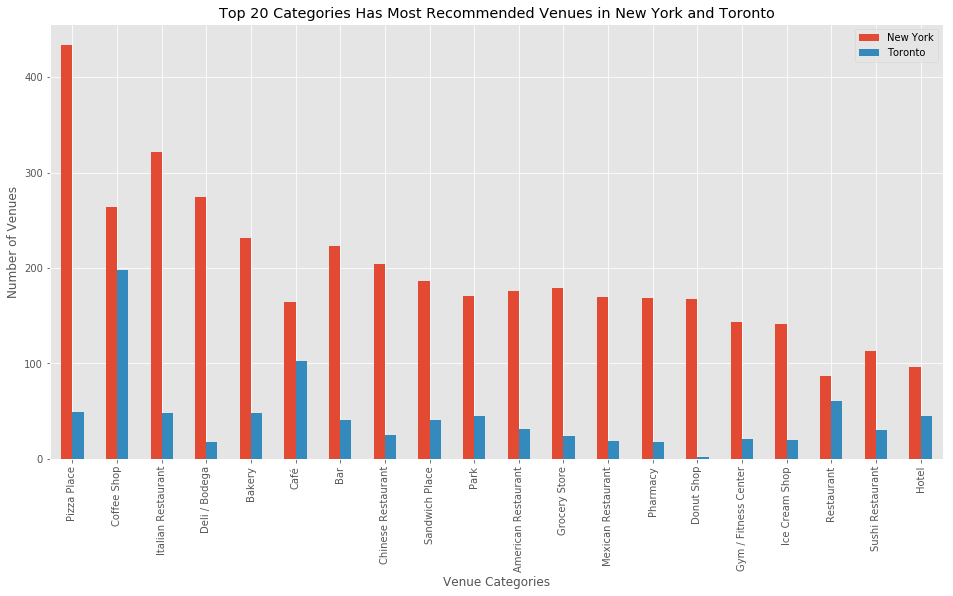

In [20]:
dfGroupByCity[["New York", "Toronto"]].head(20).plot(kind='bar', figsize=(16, 8))

plt.xlabel('Venue Categories') # add to x-label to the plot
plt.ylabel('Number of Venues') # add y-label to the plot
plt.title('Top 20 Categories Has Most Recommended Venues in New York and Toronto') # add title to the plot

plt.show()

In [21]:
# TOP 20 CATEGORIES BY NEIGHBORHOODS IN 2 CITY NEW YORK AND TORONTO
dfTop20VenuesByNeighborhood = getCategoryGroupByObject(dfRVenues, 'Neighborhood',20)
dfTop20VenuesByNeighborhood

,Neighborhood,1st Most Common Category,2nd Most Common Category,3rd Most Common Category,4th Most Common Category,5th Most Common Category,6th Most Common Category,7th Most Common Category,8th Most Common Category,9th Most Common Category,...,11th Most Common Category,12th Most Common Category,13th Most Common Category,14th Most Common Category,15th Most Common Category,16th Most Common Category,17th Most Common Category,18th Most Common Category,19th Most Common Category,20th Most Common Category
0,"Agincourt), Toronto",Breakfast Spot,Chinese Restaurant,Lounge,Sandwich Place,Skating Rink,Yoga Studio,Factory,Electronics Store,Empanada Restaurant,...,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Falafel Restaurant,Duty-free Shop,Farm,Farmers Market,Fast Food Restaurant
1,"Alderwood / Long Branch, Toronto",Pizza Place,Pub,Gym,Sandwich Place,Athletics & Sports,Skating Rink,Coffee Shop,Bank,Pool,...,English Restaurant,Flea Market,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Fishing Store,Empanada Restaurant,Fish Market,Fish & Chips Shop
2,"Allerton, New York",Spa,Chinese Restaurant,Pizza Place,Supermarket,Cosmetics Shop,Dessert Shop,Breakfast Spot,Fried Chicken Joint,Fast Food Restaurant,...,Martial Arts Dojo,Electronics Store,Food,Donut Shop,Discount Store,Pharmacy,Grocery Store,Department Store,Playground,Deli / Bodega
3,"Annadale, New York",Cosmetics Shop,Restaurant,Sports Bar,Bakery,Train Station,Diner,Pharmacy,Pizza Place,Food,...,Coworking Space,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Factory
4,"Arden Heights, New York",Coffee Shop,Deli / Bodega,Pharmacy,Business Service,Pizza Place,Bus Stop,Yoga Studio,Falafel Restaurant,Empanada Restaurant,...,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Factory,Farm,Eastern European Restaurant,Farmers Market,Fast Food Restaurant
5,"Arlington, New York",Food Service,Bus Stop,Grocery Store,Coffee Shop,American Restaurant,Deli / Bodega,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,...,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Eastern European Restaurant,Fast Food Restaurant,Field
6,"Arrochar, New York",Bus Stop,Italian Restaurant,Bagel Shop,Deli / Bodega,Cosmetics Shop,Sandwich Place,Mediterranean Restaurant,Taco Place,Bar,...,Dance Studio,Middle Eastern Restaurant,Supermarket,Food Truck,Hotel,Fish & Chips Shop,Fast Food Restaurant,Empanada Restaurant,Flower Shop,English Restaurant
7,"Arverne, New York",Surf Spot,Metro Station,Sandwich Place,Bus Stop,Thai Restaurant,Beach,Board Shop,Donut Shop,Playground,...,Pizza Place,Eye Doctor,Factory,Yoga Studio,Exhibit,Event Space,Event Service,Ethiopian Restaurant,Falafel Restaurant,Farmers Market
8,"Astoria Heights, New York",Bowling Alley,Playground,Supermarket,Burger Joint,Bus Station,Shopping Mall,Bakery,Pizza Place,Italian Restaurant,...,Plaza,Hostel,English Restaurant,Ethiopian Restaurant,Curling Ice,Event Service,Event Space,Exhibit,Eye Doctor,Factory
9,"Astoria, New York",Hookah Bar,Middle Eastern Restaurant,Bar,Seafood Restaurant,Bakery,Greek Restaurant,Pizza Place,Pub,Italian Restaurant,...,Gourmet Shop,Latin American Restaurant,Gym / Fitness Center,Food Truck,Salon / Barbershop,Cajun / Creole Restaurant,Gym,Mediterranean Restaurant,Deli / Bodega,Indian Restaurant


In [22]:
dfGroupByNeighborhood = getCategoryGroup(dfRVenues, "Neighborhood")
dfGroupByNeighborhood['Total'] = dfGroupByNeighborhood.sum(axis=1)
dfGroupByNeighborhood.sort_values(['Total'], ascending=False, axis=0, inplace=True)
# NOTE: To simplify the data to represent, I decrease the venues of 369 neighborhoods to 6 which have the most total venues by category.
# GET TOP 6 NEIGHBORHOODS HAVE THE MOST TOTAL VENUES BY CATEGORY
dfGroupByNeighborhood.head(6)

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,...,Waste Facility,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Total
227,"Murray Hill, New York",0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,144
59,"Chelsea, New York",0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,1,0,104
368,"Yorkville, New York",0,0,0,0,0,0,0,0,0,...,0,0,0,0,2,2,0,0,0,100
75,"Commerce Court / Victoria Hotel, Toronto",0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,100
276,"Richmond / Adelaide / King, Toronto",0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,100
42,"Brooklyn Heights, New York",0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,2,0,0,5,100


In [23]:
# transpose dataframe
dfTransposeGroupByNeighborhood = dfGroupByNeighborhood[list(dfGroupByNeighborhood.columns[1:-1])].transpose()
dfTransposeGroupByNeighborhood.columns = list(dfGroupByNeighborhood["Neighborhood"])
df6Neighborhood = dfTransposeGroupByNeighborhood[list(dfTransposeGroupByNeighborhood.columns[0:6])]

df6Neighborhood['Total'] = df6Neighborhood.sum(axis=1)
df6Neighborhood.sort_values(['Total'], ascending=False, axis=0, inplace=True)
# GET TOP 20 CATEGORIES HAVE THE MOST VENUES IN TOP 6 NEIGHBORHOOD
df6Neighborhood.head(20)

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,"Murray Hill, New York","Chelsea, New York","Yorkville, New York","Commerce Court / Victoria Hotel, Toronto","Richmond / Adelaide / King, Toronto","Brooklyn Heights, New York",Total
Coffee Shop,4,6,7,15,5,2,39
Italian Restaurant,3,6,6,2,1,4,22
Korean Restaurant,21,0,0,0,0,0,21
Bar,5,1,6,2,3,3,20
Hotel,4,3,0,7,3,0,17
Café,3,1,1,6,4,1,16
American Restaurant,3,3,0,4,4,2,16
Bakery,3,5,1,2,2,2,15
Deli / Bodega,2,0,3,3,2,4,14
Gym / Fitness Center,3,2,2,2,2,3,14


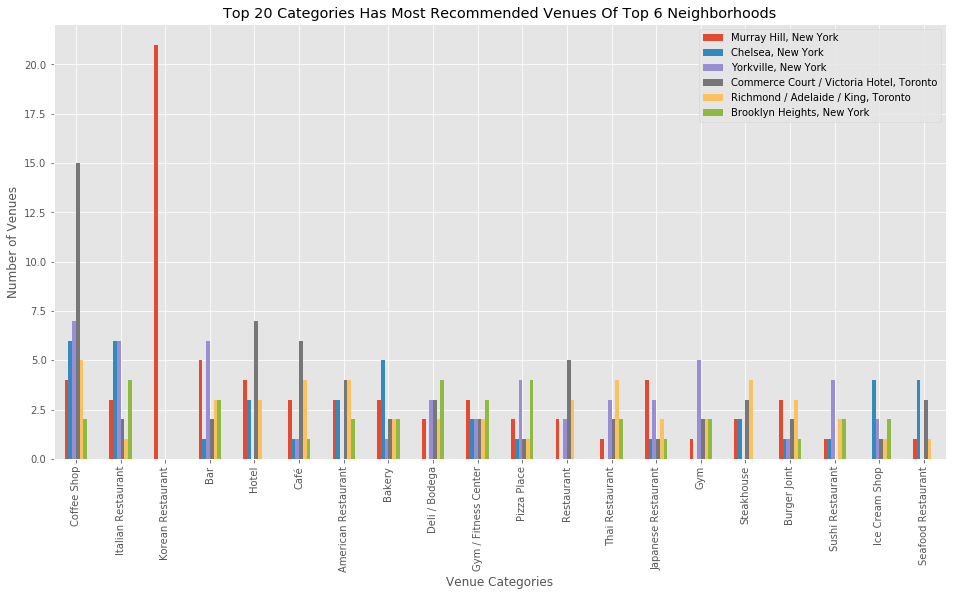

In [24]:
df6Neighborhood[df6Neighborhood.columns[0:6]].head(20).plot(kind='bar', figsize=(16, 8))

plt.xlabel('Venue Categories') # add to x-label to the plot
plt.ylabel('Number of Venues') # add y-label to the plot
plt.title('Top 20 Categories Has Most Recommended Venues Of Top 6 Neighborhoods') # add title to the plot

plt.show()

In [41]:
# NOTE: Because API endpoint Details of FOURSQUARE is PREMIUM 
# I decided to use API endpoint Likes as a alternative method to get the number of likes
def getDetailVenues(venueIds):
    
    venues_list=[]
    for venueId in zip(venueIds):
        # create the API request URL
        #url = 'https://api.foursquare.com/v2/venues/{}'.format(venueId)
        url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(
            venueId[0],
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
        
        # make the GET request
        result = requests.get(url).json()
        if "code" not in result["meta"] or result["meta"]["code"] != 200:
            print("No info at Venue ID {0} with CODE {1}".format(venueId[0], result["meta"]["code"] if 'code' in result["meta"] else "UNKNOWN"))
            return None
        try:
            response = result['response']
            print(venueId[0] + " - " + response['venue']['location']['city'])
            checkinsCount = 0
            usersCount = 0
            visitsCount = 0
            if 'checkinsCount' in response['venue']['stats']:
                checkinsCount = response['venue']['stats']['checkinsCount']
            if 'usersCount' in response['venue']['stats']:
                usersCount = response['venue']['stats']['usersCount']
            if 'visitsCount' in response['venue']['stats']:
                visitsCount = response['venue']['stats']['visitsCount']
            # return only relevant information
            venues_list.append((
                response['venue']['location']['state'],
                response['venue']['location']['city'],
                response['venue']['id'],
                response['venue']['name'], 
                response['venue']['location']['lat'], 
                response['venue']['location']['lng'],  
                response['venue']['location']['formattedAddress'][0],
                response['venue']['categories'][0]['id'],
                response['venue']['categories'][0]['name'],
                response['venue']['categories'][0]['icon']['prefix'] + response['venue']['categories'][0]['icon']['suffix'],
                checkinsCount,
                usersCount,
                visitsCount,
                response['venue']['likes']['checkinsCount'] if 'checkinsCount' in response['venue']['likes'] else 0,
                response['venue']['likes']['count'] if 'count' in response['venue']['likes'] else 0,
                response['venue']['rating'] if 'rating' in response['venue'] else 0,
                response['venue']['tips']['count'] if 'count' in response['venue']['tips'] else 0,
                response['venue']['tips']['groups'][0]['items']))
        except:
            print("Unexpected error!")
            print(result)
            continue
    
    columns = ['State', 'City', 'Venue ID', 'Venue Name', 'Venue Latitude', 'Venue Longitude', 'Venue Address', 
                  'Category ID',  'Category Name',  'Category ICON', 'Checkins', 'Users', 'Visits', 'Checkins', 'Likes', 'Rating', 'Tips Count', 'Tips Items']
    dfDetailVenues = pd.DataFrame.from_records(venues_list, columns=columns)
    
    
    return(dfDetailVenues)

In [26]:
def getSummaryUsersLikedVenues(df):
    for rowIndex in range(0,df.shape[0]):
        venueId = df.iloc[rowIndex,6]
        
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/{}/likes?client_id={}&client_secret={}&v={}'.format(
            venueId,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
        
        # make the GET request
        result = requests.get(url).json()
        if "code" not in result["meta"] or result["meta"]["code"] != 200:
            print("No info at Venue ID {0} with CODE {1}".format(venueId, result["meta"]["code"] if 'code' in result["meta"] else "UNKNOWN"))
            return None
        response = result['response']
        # return only relevant information
        likes = response['likes']['count']
        df.iloc[rowIndex, df.columns.get_loc('Likes')] = likes
    
    return df

In [28]:
# Because the limitation of Foursquare Regular Accounts 
# as well as the number of venues of categories in New York is more than in Toronto
# I decided to get data frame of venues by top 20 categories and in New York only
print("Size of venues before filtering: {0}".format(dfRVenues.shape))
listCategories = list(df6Neighborhood[list(df6Neighborhood.columns[0:6]) + ["Total"]].head(20).index)
#print(listCategories)
dfFilteredRVenues = dfRVenues[(dfRVenues['Category Name'].isin(listCategories)) & (dfRVenues['City'] == 'New York')]
dfFilteredRVenues["Likes"] = 0
print("Size of venues after filtering: {0}".format(dfFilteredRVenues.shape))
dfFilteredRVenues.head(5)

Size of venues before filtering: (12374, 14)
Size of venues after filtering: (3233, 15)


/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,City,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Number of Recommendation,Recommend Reason,Venue ID,Venue Name,Venue Latitude,Venue Longitude,Venue Address,Category ID,Category Name,Category ICON,Likes
3,New York,Wakefield,40.894705,-73.847201,0,This spot is popular,4c783cef3badb1f7e4244b54,Carvel Ice Cream,40.890487,-73.848568,1006 E 233rd St,4bf58dd8d48988d1c9941735,Ice Cream Shop,https://ss3.4sqi.net/img/categories_v2/food/ic...,0
8,New York,Co-op City,40.874294,-73.829939,0,This spot is popular,4d2cfa5cad25224bbbc5fb8f,Capri II Pizza,40.876374,-73.829940,Dreiser Loop,4bf58dd8d48988d1ca941735,Pizza Place,https://ss3.4sqi.net/img/categories_v2/food/pi...,0
12,New York,Co-op City,40.874294,-73.829939,0,This spot is popular,4bd8bbfbe914a5932f4854fa,Baskin Robbins,40.870045,-73.829578,2035 Bartow Ave,4bf58dd8d48988d1c9941735,Ice Cream Shop,https://ss3.4sqi.net/img/categories_v2/food/ic...,0
14,New York,Co-op City,40.874294,-73.829939,0,This spot is popular,4be2b79d660ec9284d04ca3b,Townhouse Restaurant,40.876086,-73.828868,129 Dreiser Loop,4bf58dd8d48988d1c4941735,Restaurant,https://ss3.4sqi.net/img/categories_v2/food/de...,0
19,New York,Co-op City,40.874294,-73.829939,0,This spot is popular,4e5b9537aeb7d78d9f923dd3,Capri Deli,40.870285,-73.828602,141 Dreiser Loop,4bf58dd8d48988d146941735,Deli / Bodega,https://ss3.4sqi.net/img/categories_v2/food/de...,0


In [29]:
# I also don't need use this function to get User Likes
# In this project, I only retrieve likes from Foursquare for first 500 venues in my data set
#df500FilteredRVenues = getSummaryUsersLikedVenues(dfFilteredRVenues.head(500))
#df500FilteredRVenues.sort_values(['Likes'], ascending=False, axis=0, inplace=True)
df500FilteredRVenues = pd.read_csv('https://raw.githubusercontent.com/timbake/TheBattleOfNeighborhoods/master/500NewYorkFilteredRVenues.csv')
df500FilteredRVenues.head()

,City,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Number of Recommendation,Recommend Reason,Venue ID,Venue Name,Venue Latitude,Venue Longitude,Venue Address,Category ID,Category Name,Category ICON,Likes
0,New York,Belmont,40.857277,-73.888452,0,This spot is popular,4aabd3e6f964a5204a5a20e3,Zero Otto Nove,40.854714,-73.888388,2357 Arthur Ave (at E 186th St),4bf58dd8d48988d1ca941735,Pizza Place,https://ss3.4sqi.net/img/categories_v2/food/pi...,217
1,New York,Throgs Neck,40.815109,-73.816350,0,This spot is popular,4b4b9f1df964a5201fa226e3,Tosca Café,40.819204,-73.817467,4034 E Tremont Ave (at Miles Ave),4bf58dd8d48988d116941735,Bar,https://ss3.4sqi.net/img/categories_v2/nightli...,167
2,New York,Edgewater Park,40.821986,-73.813885,0,This spot is popular,4b4b9f1df964a5201fa226e3,Tosca Café,40.819204,-73.817467,4034 E Tremont Ave (at Miles Ave),4bf58dd8d48988d116941735,Bar,https://ss3.4sqi.net/img/categories_v2/nightli...,167
3,New York,Belmont,40.857277,-73.888452,0,This spot is popular,4acf80aef964a52025d420e3,Tino's Delicatessen,40.855882,-73.887166,2410 Arthur Ave (E. 187 St.),4bf58dd8d48988d110941735,Italian Restaurant,https://ss3.4sqi.net/img/categories_v2/food/it...,137
4,New York,Belmont,40.857277,-73.888452,0,This spot is popular,50e600a4526287052c53bb99,The Bronx Beer Hall,40.854198,-73.888233,2344 Arthur Ave (btwn E186th St & E 184th St),4bf58dd8d48988d116941735,Bar,https://ss3.4sqi.net/img/categories_v2/nightli...,129


## GET TOP 10 VENUES HAVE THE MOST TOTAL USER LIKES IN NEW YORK CITY

In [30]:
dfTop10VenuesUserLikes = df500FilteredRVenues[['Venue Name', 'Likes']].groupby('Venue Name').sum().reset_index()
dfTop10VenuesUserLikes.sort_values(['Likes'], ascending=False, axis=0, inplace=True)
dfTop10VenuesUserLikes = dfTop10VenuesUserLikes.reset_index(drop=True)
dfTop10VenuesUserLikes.head(10)

,Venue Name,Likes
0,Tosca Café,334
1,Dunkin' Donuts,284
2,Dunkin Donuts,267
3,Zero Otto Nove,217
4,Rite Aid,164
5,Planet Fitness,160
6,Tino's Delicatessen,137
7,The Bronx Beer Hall,129
8,Taqueria Tlaxcali,122
9,The Kettle Black,115


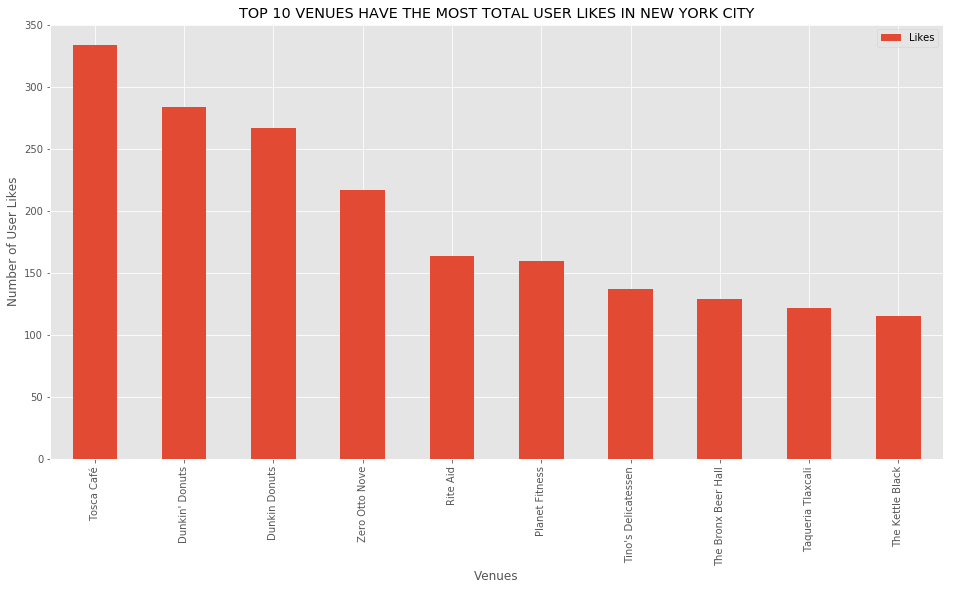

In [31]:
temp = dfTop10VenuesUserLikes.head(10)
temp.set_index('Venue Name', inplace=True)
temp.plot(kind='bar', figsize=(16, 8))

plt.xlabel('Venues') # add to x-label to the plot
plt.ylabel('Number of User Likes') # add y-label to the plot
plt.title('TOP 10 VENUES HAVE THE MOST TOTAL USER LIKES IN NEW YORK CITY') # add title to the plot

plt.show()

## GET TOP 10 CATEGORIES HAVE THE MOST TOTAL USER LIKES IN NEW YORK CITY

In [32]:
dfTop10CatesUserLikes = df500FilteredRVenues[['Category Name', 'Likes']].groupby('Category Name').sum().reset_index()
dfTop10CatesUserLikes.sort_values(['Likes'], ascending=False, axis=0, inplace=True)
dfTop10CatesUserLikes = dfTop10CatesUserLikes.reset_index(drop=True)
dfTop10CatesUserLikes.head(10)

,Category Name,Likes
0,Italian Restaurant,1134
1,Pizza Place,1040
2,Bar,816
3,Donut Shop,551
4,Mexican Restaurant,449
5,Deli / Bodega,376
6,Pharmacy,368
7,American Restaurant,346
8,Bakery,297
9,Park,293


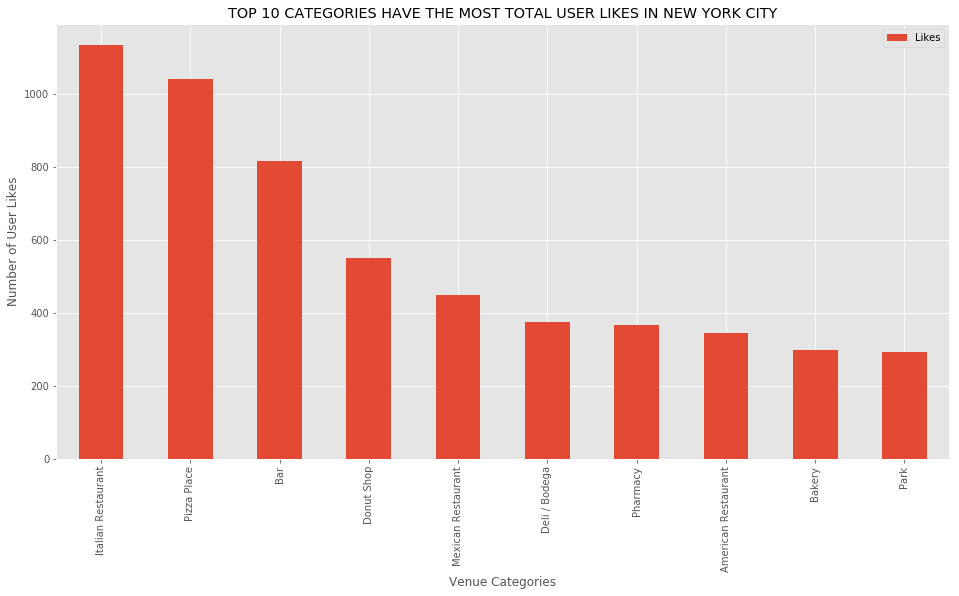

In [33]:
temp = dfTop10CatesUserLikes.head(10)
temp.set_index('Category Name', inplace=True)
temp.plot(kind='bar', figsize=(16, 8))

plt.xlabel('Venue Categories') # add to x-label to the plot
plt.ylabel('Number of User Likes') # add y-label to the plot
plt.title('TOP 10 CATEGORIES HAVE THE MOST TOTAL USER LIKES IN NEW YORK CITY') # add title to the plot

plt.show()

## TOP 5 VENUES HAVE THE HIGHEST RATING BY CATEGORY IN CITY, NEIGHBORHOOD

In [36]:
# NOTE: Because the limitation of Foursquare PREMIUM account, I only get 10 venues have the most user likes to statistic and report
# Filter data frame to list of 10 venues have the most user likes
list10Venues = list(dfTop10VenuesUserLikes.head(10)['Venue Name'])
df10RVenues = df500FilteredRVenues[df500FilteredRVenues['Venue Name'].isin(list10Venues)]
# Get venue id list
listVenueIds = list(df10RVenues['Venue ID'])

In [37]:
def removeDuplicate(duplicate):
    result = []
    for num in duplicate:
        if num not in result:
            result.append(num)
    return result

In [39]:
listVenueIds = removeDuplicate(listVenueIds)
print("We have the number of different venues: {}".format(len(listVenueIds)))

We have the number of different venues: 67


In [42]:
# CAUTION: Because the limitation of endpoint DETAILS of Foursquare is 50 calls per day, I need to reduce the number of venues to 20 instead of 67
# df20RVenuesDetail = getDetailVenues(listVenueIds[:20])
df20RVenuesDetail = pd.read_csv('https://raw.githubusercontent.com/timbake/TheBattleOfNeighborhoods/master/20NewYorkRVenuesDetail.csv')
df20RVenuesDetail

,State,City,Venue ID,Venue Name,Venue Latitude,Venue Longitude,Venue Address,Category ID,Category Name,Category ICON,Checkins,Users,Visits,Checkins.1,Likes,Rating,Tips Count,Tips Items
0,NY,Bronx,4aabd3e6f964a5204a5a20e3,Zero Otto Nove,40.854714,-73.888388,2357 Arthur Ave (at E 186th St),4bf58dd8d48988d1ca941735,Pizza Place,https://ss3.4sqi.net/img/categories_v2/food/pi...,0,0,0,0,217,9.4,71,"[{'id': '4f567ec5e4b0377eee23fdd8', 'createdAt..."
1,NY,Bronx,4b4b9f1df964a5201fa226e3,Tosca Café,40.819204,-73.817467,4034 E Tremont Ave (at Miles Ave),4bf58dd8d48988d116941735,Bar,https://ss3.4sqi.net/img/categories_v2/nightli...,0,0,0,0,167,8.4,60,"[{'id': '4c61ec8bde1b2d7f112fe170', 'createdAt..."
2,NY,Bronx,4acf80aef964a52025d420e3,Tino's Delicatessen,40.855882,-73.887166,2410 Arthur Ave (E. 187 St.),4bf58dd8d48988d110941735,Italian Restaurant,https://ss3.4sqi.net/img/categories_v2/food/it...,0,0,0,0,137,9.4,47,"[{'id': '54b00871498e43e9430459ef', 'createdAt..."
3,NY,Bronx,50e600a4526287052c53bb99,The Bronx Beer Hall,40.854198,-73.888233,2344 Arthur Ave (btwn E186th St & E 184th St),4bf58dd8d48988d116941735,Bar,https://ss3.4sqi.net/img/categories_v2/nightli...,0,0,0,0,129,8.6,32,"[{'id': '51d1f1d5498ea8d228968e41', 'createdAt..."
4,NY,Bronx,4b4929d2f964a520656826e3,Taqueria Tlaxcali,40.836098,-73.854948,2103 Starling Ave (Olmstead St & Odell St),4bf58dd8d48988d1c1941735,Mexican Restaurant,https://ss3.4sqi.net/img/categories_v2/food/me...,0,0,0,0,122,9.3,71,"[{'id': '4f39a8f0e4b0a81c49370092', 'createdAt..."
5,NY,Brooklyn,4a9880f5f964a520692c20e3,The Kettle Black,40.622839,-74.031411,8622 3rd Ave (at 87th St.),4bf58dd8d48988d116941735,Bar,https://ss3.4sqi.net/img/categories_v2/nightli...,0,0,0,0,115,8.1,46,"[{'id': '4cd56c364ebba090b29ba9d6', 'createdAt..."
6,NY,Bronx,4f5ce789e4b0a4baa3d5dbb6,Planet Fitness,40.863298,-73.835568,1780 E Gun Hill Rd,4bf58dd8d48988d175941735,Gym / Fitness Center,https://ss3.4sqi.net/img/categories_v2/buildin...,0,0,0,0,76,8.0,15,"[{'id': '520b4e7d11d2aa31988c4e0b', 'createdAt..."
7,NY,Bronx,4b5357adf964a520319827e3,Dunkin' Donuts,40.876993,-73.906507,5501 Broadway (W 230th St),4bf58dd8d48988d148941735,Donut Shop,https://ss3.4sqi.net/img/categories_v2/food/do...,0,0,0,0,65,7.5,14,"[{'id': '53907eee498e51b2f6158488', 'createdAt..."
8,NY,Bronx,4ba92d21f964a5209e113ae3,Dunkin' Donuts,40.852560,-73.827359,3276 Westchester Ave,4bf58dd8d48988d148941735,Donut Shop,https://ss3.4sqi.net/img/categories_v2/food/do...,0,0,0,0,51,7.5,5,"[{'id': '520d001111d23d6d81051a6f', 'createdAt..."
9,NY,Bronx,462d15a3f964a520e7451fe3,Planet Fitness,40.848290,-73.830875,3060 Westchester Ave,4bf58dd8d48988d175941735,Gym / Fitness Center,https://ss3.4sqi.net/img/categories_v2/buildin...,0,0,0,0,49,7.3,17,"[{'id': '4e7abfbcfa76e8ee772998f4', 'createdAt..."
